Loading polblogs dataset...
Skipping node 1395 due to zero loss or negligible gradients.
Skipping node 35 due to zero loss or negligible gradients.
Skipping node 754 due to zero loss or negligible gradients.
Skipping node 1169 due to zero loss or negligible gradients.
Skipping node 362 due to zero loss or negligible gradients.
Skipping node 1183 due to zero loss or negligible gradients.
Skipping node 597 due to zero loss or negligible gradients.
Skipping node 255 due to zero loss or negligible gradients.
Skipping node 1036 due to zero loss or negligible gradients.
Skipping node 1008 due to zero loss or negligible gradients.
Skipping node 1046 due to zero loss or negligible gradients.
Skipping node 146 due to zero loss or negligible gradients.
Skipping node 1486 due to zero loss or negligible gradients.
Skipping node 1057 due to zero loss or negligible gradients.
Skipping node 1403 due to zero loss or negligible gradients.
Skipping node 85 due to zero loss or negligible gradients.
Skipp

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (207, 1477)
Gradient: 0.012218998745083809
Number of common neighbors: 1
Score: 1.0122189987450838
Added edge: (207, 675)
Gradient: -0.031841665506362915
Number of common neighbors: 2
Score: 1.968158334493637
Added edge: (207, 1050)
Gradient: 0.04458780586719513
Number of common neighbors: 2
Score: 2.044587805867195
Added edge: (207, 1436)
Gradient: 0.03565814718604088
Number of common neighbors: 3
Score: 3.035658147186041
Target node is: 379 with label: 0
Added edge: (379, 854)
Gradient: 3.5294878482818604
Number of common neighbors: 0
Score: 3.5294878482818604
Added edge: (379, 1100)
Gradient: 1.9928520917892456
Number of common neighbors: 1
Score: 2.9928520917892456
Added edge: (379, 879)
Gradient: 1.7394003868103027
Number of common neighbors: 2
Score: 3.7394003868103027
Added edge: (379, 1111)
Gradient: 1.5857696533203125
Number of common neighbors: 3
Score: 4.5857696533203125
Target node is: 681 with label: 0
Added edge: (681, 854)
Gradient: 47.33993148803711
Number o

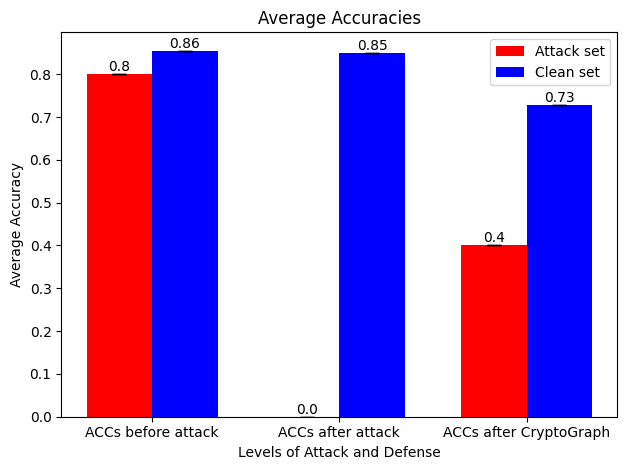

In [7]:
########  scenario 3 indirect: surrogate: adj, ACC1:adj, attaque:adj, ACC2: adj^,   Crypto'Graph: adj^, adj2  , ACC3: adj*
# mahsa-V7 : improvements on V5.1 : changing to remove edges too. change: calculate_edge_scores_all_actions and perturb_edges_between_targets_all_actions
# now it considers just ACC3 for adj1 after CG defense.
# initial train on adj1  -DONE BEFORE ATTACK in the main execution

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss



    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)


### change to consider all actions (add/remove) for each target node
def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
            if not scores:
                break
            # Select the edge and action with the highest score
            best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
            edge = (best_edge_info[0], best_edge_info[1])
            action = best_edge_info[2]
            score = best_edge_info[3]
            delta_loss = best_edge_info[4]
            common_neighbors = best_edge_info[5]

            if action == 'add':
                # Perform add
                attacked_adj[edge[0], edge[1]] = 1
                attacked_adj[edge[1], edge[0]] = 1
                added_edges.append(edge)
                edge_added_count += 1
                print(f"Added edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")
            elif action == 'remove':
                # Perform remove
                attacked_adj[edge[0], edge[1]] = 0
                attacked_adj[edge[1], edge[0]] = 0
                removed_edges.append(edge)
                edge_removed_count += 1
                print(f"Removed edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}") 
    return attacked_adj, added_edges, removed_edges






# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 0    # Number of nodes with maximum loss and gradients
min_count = 5    # Number of nodes with minimum loss and gradients
moyen_count = 0  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 4 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Use only the accuracy for the first part of the graph (adj1)
# accuracy_test_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
# accuracy_test_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set

#Use only the accuracy for the first part of the graph (adj2)
accuracy_test_attack_3_adj1 = accuracy_test_attack_3[1]  # second part for attack set
accuracy_test_clean_3_adj1 = accuracy_test_clean_3[1]  # second part for clean set


# Function to find removed edges
# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_adj1)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_adj1)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
########  scenario 4 indirect: surrogate: adj, ACC1:adj1, attaque:adj1, ACC2: adj1^,   Crypto'Graph: adj1^, adj2  , ACC3: adj1*
# mahsa-V7 : improvements on V5.1 : changing to remove edges too. change: calculate_edge_scores_all_actions and perturb_edges_between_targets_all_actions
# now it considers just ACC3 for adj1 after CG defense.
# initial train on adj1  -DONE BEFORE ATTACK in the main execution

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss



    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)


### change to consider all actions (add/remove) for each target node
def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
            if not scores:
                break
            # Select the edge and action with the highest score
            best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
            edge = (best_edge_info[0], best_edge_info[1])
            action = best_edge_info[2]
            score = best_edge_info[3]
            delta_loss = best_edge_info[4]
            common_neighbors = best_edge_info[5]

            if action == 'add':
                # Perform add
                attacked_adj[edge[0], edge[1]] = 1
                attacked_adj[edge[1], edge[0]] = 1
                added_edges.append(edge)
                edge_added_count += 1
                print(f"Added edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")
            elif action == 'remove':
                # Perform remove
                attacked_adj[edge[0], edge[1]] = 0
                attacked_adj[edge[1], edge[0]] = 0
                removed_edges.append(edge)
                edge_removed_count += 1
                print(f"Removed edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}") 
    return attacked_adj, added_edges, removed_edges






# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 0    # Number of nodes with maximum loss and gradients
min_count = 5    # Number of nodes with minimum loss and gradients
moyen_count = 0  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 4 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Use only the accuracy for the first part of the graph (adj1)
# accuracy_test_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
# accuracy_test_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set

#Use only the accuracy for the first part of the graph (adj2)
accuracy_test_attack_3_adj1 = accuracy_test_attack_3[1]  # second part for attack set
accuracy_test_clean_3_adj1 = accuracy_test_clean_3[1]  # second part for clean set



# Function to find removed edges
# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_adj1)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_adj1)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Skipping node 1395 due to zero loss or negligible gradients.
Skipping node 35 due to zero loss or negligible gradients.
Skipping node 754 due to zero loss or negligible gradients.
Skipping node 1169 due to zero loss or negligible gradients.
Skipping node 362 due to zero loss or negligible gradients.
Skipping node 1183 due to zero loss or negligible gradients.
Skipping node 597 due to zero loss or negligible gradients.
Skipping node 255 due to zero loss or negligible gradients.
Skipping node 1036 due to zero loss or negligible gradients.
Skipping node 1008 due to zero loss or negligible gradients.
Skipping node 1046 due to zero loss or negligible gradients.
Skipping node 146 due to zero loss or negligible gradients.
Skipping node 1486 due to zero loss or negligible gradients.
Skipping node 1057 due to zero loss or negligible gradients.
Skipping node 1403 due to zero loss or negligible gradients.
Skipping node 85 due to zero loss or negligible gradients.
Skipp

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1182, 511)
Gradient: 0.00620215805247426
Number of common neighbors: 1
Score: 1.0062021580524743
Added edge: (1182, 322)
Gradient: 0.006137276068329811
Number of common neighbors: 2
Score: 2.00613727606833
Added edge: (1182, 12)
Gradient: 0.0024876317474991083
Number of common neighbors: 3
Score: 3.002487631747499
Added edge: (1182, 154)
Gradient: 0.01068545039743185
Number of common neighbors: 3
Score: 3.010685450397432
Target node is: 716 with label: 0
Added edge: (716, 658)
Gradient: -0.0008637043065391481
Number of common neighbors: 1
Score: 0.9991362956934609
Added edge: (716, 1020)
Gradient: 0.0016720963176339865
Number of common neighbors: 1
Score: 1.001672096317634
Removed edge: (716, 658)
Gradient: -0.0008637043065391481
Number of common neighbors: 2
Score: 2.000863704306539
Added edge: (716, 658)
Gradient: -0.0008637043065391481
Number of common neighbors: 2
Score: 1.9991362956934609
Target node is: 207 with label: 0
Added edge: (207, 854)
Gradient: 26.6321086883

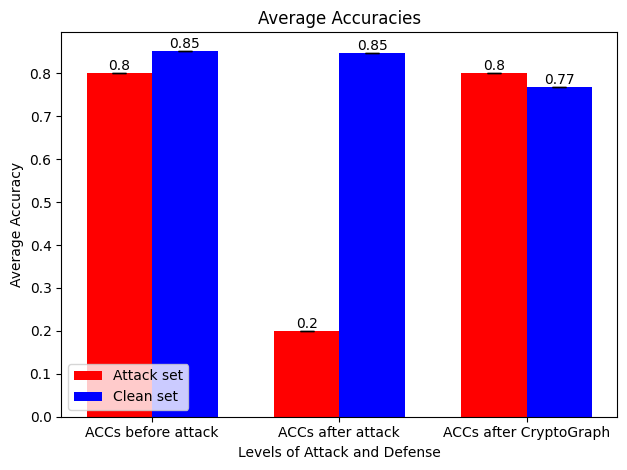

In [9]:
########  scenario 5 indirect: surrogate: adj1, ACC1:adj, attaque:adj, ACC2: adj^,   Crypto'Graph: adj^, adj2  , ACC3: adj*
# mahsa-V7 : improvements on V5.1 : changing to remove edges too. change: calculate_edge_scores_all_actions and perturb_edges_between_targets_all_actions
# now it considers just ACC3 for adj1 after CG defense.
# initial train on adj1  -DONE BEFORE ATTACK in the main execution

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss



    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)


### change to consider all actions (add/remove) for each target node
def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
            if not scores:
                break
            # Select the edge and action with the highest score
            best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
            edge = (best_edge_info[0], best_edge_info[1])
            action = best_edge_info[2]
            score = best_edge_info[3]
            delta_loss = best_edge_info[4]
            common_neighbors = best_edge_info[5]

            if action == 'add':
                # Perform add
                attacked_adj[edge[0], edge[1]] = 1
                attacked_adj[edge[1], edge[0]] = 1
                added_edges.append(edge)
                edge_added_count += 1
                print(f"Added edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")
            elif action == 'remove':
                # Perform remove
                attacked_adj[edge[0], edge[1]] = 0
                attacked_adj[edge[1], edge[0]] = 0
                removed_edges.append(edge)
                edge_removed_count += 1
                print(f"Removed edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}") 
    return attacked_adj, added_edges, removed_edges



# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj1, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 0    # Number of nodes with maximum loss and gradients
min_count = 5    # Number of nodes with minimum loss and gradients
moyen_count = 0  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 4 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Use only the accuracy for the first part of the graph (adj1)
# accuracy_test_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
# accuracy_test_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set

#Use only the accuracy for the first part of the graph (adj2)
accuracy_test_attack_3_adj1 = accuracy_test_attack_3[1]  # second part for attack set
accuracy_test_clean_3_adj1 = accuracy_test_clean_3[1]  # second part for clean set




# Function to find removed edges
# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_adj1)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_adj1)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Skipping node 1395 due to zero loss or negligible gradients.
Skipping node 35 due to zero loss or negligible gradients.
Skipping node 754 due to zero loss or negligible gradients.
Skipping node 1169 due to zero loss or negligible gradients.
Skipping node 362 due to zero loss or negligible gradients.
Skipping node 1183 due to zero loss or negligible gradients.
Skipping node 597 due to zero loss or negligible gradients.
Skipping node 255 due to zero loss or negligible gradients.
Skipping node 1036 due to zero loss or negligible gradients.
Skipping node 1008 due to zero loss or negligible gradients.
Skipping node 1046 due to zero loss or negligible gradients.
Skipping node 146 due to zero loss or negligible gradients.
Skipping node 1486 due to zero loss or negligible gradients.
Skipping node 1057 due to zero loss or negligible gradients.
Skipping node 1403 due to zero loss or negligible gradients.
Skipping node 85 due to zero loss or negligible gradients.
Skipp

C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1182, 154)
Gradient: 140.4212646484375
Number of common neighbors: 0
Score: 140.4212646484375
Added edge: (1182, 54)
Gradient: 131.69459533691406
Number of common neighbors: 1
Score: 132.69459533691406
Added edge: (1182, 640)
Gradient: 127.2242431640625
Number of common neighbors: 2
Score: 129.2242431640625
Added edge: (1182, 362)
Gradient: 100.7009506225586
Number of common neighbors: 3
Score: 103.7009506225586
Target node is: 716 with label: 0
Added edge: (716, 658)
Gradient: -0.0021505900658667088
Number of common neighbors: 1
Score: 0.9978494099341333
Added edge: (716, 1020)
Gradient: 0.0024668220430612564
Number of common neighbors: 1
Score: 1.0024668220430613
Removed edge: (716, 658)
Gradient: -0.0021505900658667088
Number of common neighbors: 2
Score: 2.0021505900658667
Added edge: (716, 159)
Gradient: -0.002076942939311266
Number of common neighbors: 2
Score: 1.9979230570606887
Target node is: 207 with label: 0
Added edge: (207, 854)
Gradient: 195.51358032226562
Nu

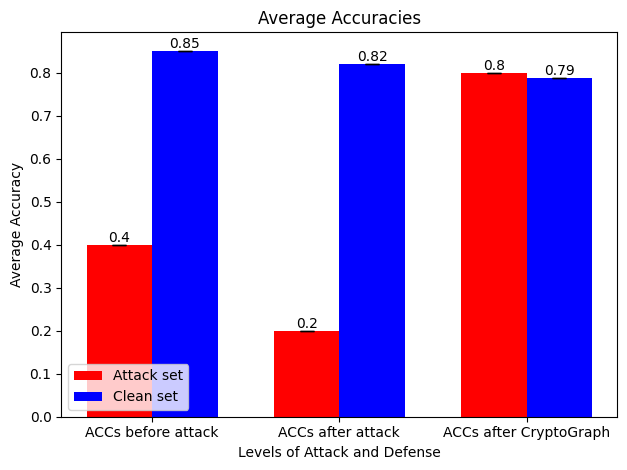

In [13]:
########  scenario 6 indirect: surrogate: adj1, ACC1:adj1, attaque:adj1, ACC2: adj1^,   Crypto'Graph: adj1^, adj2  , ACC3: adj1*
# mahsa-V7 : improvements on V5.1 : changing to remove edges too. change: calculate_edge_scores_all_actions and perturb_edges_between_targets_all_actions
# now it considers just ACC3 for adj1 after CG defense.
# initial train on adj1  -DONE BEFORE ATTACK in the main execution

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count=0, min_count=0, moyen_count=0, manual_nodes=None):
    if manual_nodes is not None and len(manual_nodes) > 0:
        print("Using manually selected nodes.")
        return [(node, 0, 0, 0) for node in manual_nodes]  # Dummy values for score, loss, gradient sum

    non_zero_loss_and_gradients_nodes = []

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        # Filter based on zero loss or negligible gradient values
        gradient_sum = np.sum(np.abs(gradients))
        if loss < 1e-5 or gradient_sum < 1e-12:  # Using a small threshold to account for numerical precision issues
            print(f"Skipping node {target_node} due to zero loss or negligible gradients.")
            continue

        impact_score = loss * gradient_sum
        non_zero_loss_and_gradients_nodes.append((target_node, impact_score, loss, gradient_sum))

    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score
    # sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: x[1])
    
    sorted_nodes = sorted(non_zero_loss_and_gradients_nodes, key=lambda x: (x[1], x[2]))  # Sort by impact score, then by loss



    # Selecting the top nodes with maximum loss and gradient
    max_nodes = sorted_nodes[-max_count:] if max_count > 0 else []
    # Selecting the bottom nodes with minimum loss and gradient
    min_nodes = sorted_nodes[:min_count] if min_count > 0 else []
    # Selecting nodes with median (moyen) loss and gradient
    median_index = len(sorted_nodes) // 2
    moyen_nodes = sorted_nodes[max(0, median_index - moyen_count//2): min(len(sorted_nodes), median_index + moyen_count//2)] if moyen_count > 0 else []

    return max_nodes, min_nodes, moyen_nodes


# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)


### change to consider all actions (add/remove) for each target node
def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append((target_node, i, action, score, delta_loss, common_neighbors))
    return scores

def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    edge_added_count = 0
    edge_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta)
            if not scores:
                break
            # Select the edge and action with the highest score
            best_edge_info = max(scores, key=lambda x: x[3])  # x[3] is the score
            edge = (best_edge_info[0], best_edge_info[1])
            action = best_edge_info[2]
            score = best_edge_info[3]
            delta_loss = best_edge_info[4]
            common_neighbors = best_edge_info[5]

            if action == 'add':
                # Perform add
                attacked_adj[edge[0], edge[1]] = 1
                attacked_adj[edge[1], edge[0]] = 1
                added_edges.append(edge)
                edge_added_count += 1
                print(f"Added edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")
            elif action == 'remove':
                # Perform remove
                attacked_adj[edge[0], edge[1]] = 0
                attacked_adj[edge[1], edge[0]] = 0
                removed_edges.append(edge)
                edge_removed_count += 1
                print(f"Removed edge: {edge}")
                print(f"Gradient: {gradients[edge[0], edge[1]]}")
                print(f"Number of common neighbors: {common_neighbors}")
                print(f"Score: {score}")

    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}") 
    return attacked_adj, added_edges, removed_edges



# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj1, labels, idx_train, idx_val)

# k = 10 # budget in the meaning of Number of nodes to attack
# nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
max_count = 0    # Number of nodes with maximum loss and gradients
min_count = 5    # Number of nodes with minimum loss and gradients
moyen_count = 0  # Number of nodes with median (moyen) loss and gradients
manual_nodes = [275, 1130, 716, 1182, 213, 121]  # List of nodes to attack manually
max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, max_count, min_count, moyen_count)
# max_nodes, min_nodes, moyen_nodes = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, manual_nodes=manual_nodes)

print("Contents of max_nodes:", max_nodes)
print("Contents of min_nodes:", min_nodes)
print("Contents of moyen_nodes:", moyen_nodes)

# Combine into nodes_to_attack
nodes_to_attack = max_nodes + min_nodes + moyen_nodes
print("Contents of nodes_to_attack:", nodes_to_attack)

# Print out node information
print("Nodes chosen for attack:")
for node_info in nodes_to_attack:
    if isinstance(node_info, tuple):
        node, score, loss, gradient_sum = node_info
        print(f"Node: {node}, Total Score: {score:.4f}, Loss: {loss:.4f}, Gradient Sum: {gradient_sum:.4f}")
    else:
        print(f"Unexpected format: {node_info} (type: {type(node_info)})")


# Extract only the node IDs from nodes_to_attack
nodes_to_attack_ids = [node_info[0] for node_info in nodes_to_attack if isinstance(node_info, tuple)]
idx_test_attack = nodes_to_attack_ids
# Identify clean nodes
idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_ids]

print("Nodes chosen for attack:", nodes_to_attack_ids)
print("Nodes that are clean:", idx_test_clean)

print("Nodes chosen for attack:", idx_test_attack)
print("Nodes that are clean:", idx_test_clean)


########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 4 # Number of edges to add or remove for each target node
alpha = 1.0
beta = 1.0
print(f" number of nodes to attack: {len(idx_test_attack)}")
print(f"budget: {budget}", f"alpha(gradient's importance): {alpha}", F"beta( commun neighbor's importance): {beta}")

attacked_adj_1, added_edges, removed_edges = perturb_edges_between_targets(adj1, surrogate_model, features, labels, idx_test_attack, budget, alpha, beta)

# Model evaluation after attack
model.fit(features, attacked_adj_1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")

threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        attacked_adj_1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Use only the accuracy for the first part of the graph (adj1)
# accuracy_test_attack_3_adj1 = accuracy_test_attack_3[0]  # First part for attack set
# accuracy_test_clean_3_adj1 = accuracy_test_clean_3[0]  # First part for clean set
# Use only the accuracy for the first part of the graph (adj2)
accuracy_test_attack_3_adj1 = accuracy_test_attack_3[1]  # second part for attack set
accuracy_test_clean_3_adj1 = accuracy_test_clean_3[1]  # second part for clean set


# Function to find removed edges
# Function to find removed edges  - should compare adj after attack and cg 
def find_removed_edges(attacked_adj_1, adj2, defended_adj1, defended_adj2):
    removed_edges = []
    attacked_adj_1 = attacked_adj_1.toarray()
    adj2 = adj2.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_attacked_adj = np.maximum(attacked_adj_1, adj2)
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(combined_attacked_adj.shape[0]):
        for j in range(i + 1, combined_attacked_adj.shape[1]):
            if combined_attacked_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj_1, adj2, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")


# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_adj1)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_adj1)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_adj1)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()
